In [124]:
import torch
import numpy as np
from time import time

import matplotlib.pyplot as plt

from torch import Tensor
from botorch import acquisition
from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan
from botorch import fit_gpytorch_model
from botorch.optim import optimize_acqf
from botorch.sampling import SobolQMCNormalSampler

from botorch.acquisition.monte_carlo import qExpectedImprovement
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Objective Function


In [125]:
lower_bound = -2
upper_bound = 3
num_of_points = 100
noise = 0

bounds = torch.tensor([[float(lower_bound)], [float(upper_bound)]])

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float


In [126]:
def target_function(points, noise):

    results = []
    for x in points:
        results.append(-np.sin(3*x) - x**2 + 0.7*x + noise)
    return torch.tensor(results)


def generate_initial_data(lower_bound, upper_bound, num_of_points, noise):

    x = np.linspace(lower_bound, upper_bound, num_of_points)
    train_x = x.reshape(num_of_points, -1)
    train_y = target_function(train_x, noise)
    best_observed_y = 0 #train_y.max().item()

    train_x = torch.tensor(train_x)
    train_y = torch.tensor(train_y)
    
    return train_x, train_y, best_observed_y


# Dense grid of points within bounds
train_X, train_Y, best_observed_y = generate_initial_data(
    lower_bound, upper_bound, num_of_points, noise)


## Data

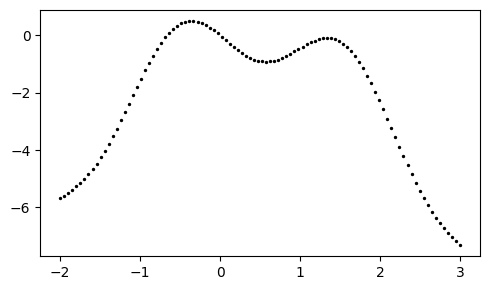

In [127]:
fig, ax = plt.subplots(figsize=(5, 3))
plt.style.context('seaborn-white')
ax.scatter(train_X, train_Y, c='k', s=2)
plt.tight_layout()

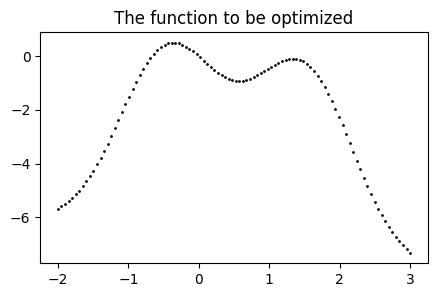

In [128]:
def plotFun(train_X, train_Y, next_observed_point, size=(8, 6)):

    fig = plt.figure(figsize=size)
    plt.style.context('seaborn-white')
    plt.scatter(train_X, train_Y, c='k', s=1)
    if next_observed_point:
        fig.gca().scatter(x=next_observed_point[0],
                    y=next_observed_point[1], c='r', linewidth=2)
    plt.title('The function to be optimized')
    plt.show();



plotFun(train_X, train_Y, None, (5, 3))


### Next Experiment

In [129]:
def train_model(train_X: Tensor, train_Y: Tensor) -> SingleTaskGP:

    model = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
    fit_gpytorch_model(mll)

    return model

In [130]:
def optimize_acqf_and_get_observation(model, train_X, bounds, n_points=1):
    
    """ 
    
    A Function to generate the next point to be evaluated.

    Args:
        init_x: The initial point
        init_y: The initial value of the function at the initial point
        best_init_y: The best value of the function seen so far
        bounds: The bounds of the function
        n_points: The number of points to generate

    Returns:
        candidate: Potential next candidate to be evaluated
    """

    acqf = acquisition.qNoisyExpectedImprovement(
        model=model,
        X_baseline=train_X,
        sampler=SobolQMCNormalSampler(128),
        prune_baseline=True,
    )


    candidate, _ = optimize_acqf(acq_function=acqf,
                                 bounds=bounds,
                                    q=n_points,
                                    num_restarts=10,
                                    raw_samples=128)
    
    new_observation = target_function(candidate, 0).unsqueeze(-1)

    return candidate, new_observation


### Optimization

Starting iteration 0, total time: 0.000 seconds.
The Best Observed Value: (tensor([[-0.3591]]), tensor([[0.5004]]))
Starting iteration 1, total time: 0.182 seconds.
The Best Observed Value: (tensor([[-0.3669]]), tensor([[0.5001]]))
Starting iteration 2, total time: 0.405 seconds.
The Best Observed Value: (tensor([[0.8504]]), tensor([[-0.6845]]))
Starting iteration 3, total time: 0.567 seconds.
The Best Observed Value: (tensor([[-0.7795]]), tensor([[-0.4337]]))
Starting iteration 4, total time: 0.729 seconds.
The Best Observed Value: (tensor([[-0.3525]]), tensor([[0.5001]]))
Starting iteration 5, total time: 0.906 seconds.
The Best Observed Value: (tensor([[-0.3473]]), tensor([[0.4996]]))
Starting iteration 6, total time: 1.163 seconds.
The Best Observed Value: (tensor([[-0.3731]]), tensor([[0.4994]]))
Starting iteration 7, total time: 1.324 seconds.
The Best Observed Value: (tensor([[2.7981]]), tensor([[-6.7284]]))
Starting iteration 8, total time: 1.493 seconds.
The Best Observed Valu

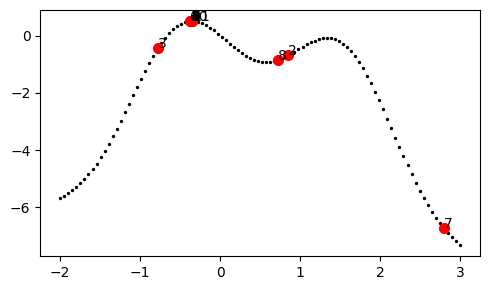

In [131]:
from cProfile import label


model = train_model(train_X, train_Y)
start_time = time()

NUM_ITERATIONS = 12

# Dense grid of points within bounds
for i in range(NUM_ITERATIONS):
    print(
        f"Starting iteration {i}, total time: {time() - start_time:.3f} seconds.")
    candidate, observation = optimize_acqf_and_get_observation(
        model, train_X, bounds, 1)

    train_X = torch.cat([train_X, candidate])
    train_Y = torch.cat([train_Y, observation])

    model = train_model(train_X, train_Y)

    print(f"The Best Observed Value: {candidate, observation}")
    next_observed_point = (candidate, observation)
    fig.gca().scatter(
        x=next_observed_point[0], 
        y=next_observed_point[1], color='r', linewidth=2)
    ax.annotate(f'{i}', next_observed_point)

fig

### Compute posterior over test points and plot fit

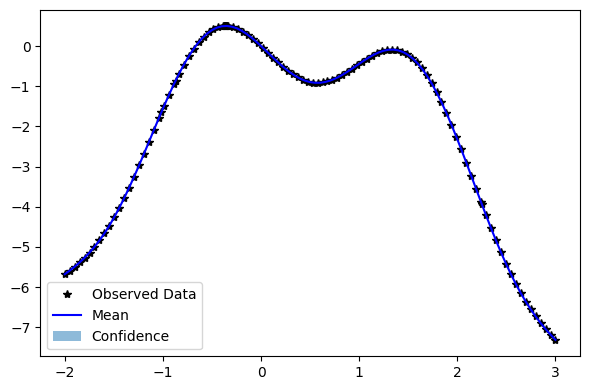

In [42]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(lower_bound, upper_bound, 101, dtype=dtype, device=device)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'k*')
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()